In [1]:
import sys
import os
sys.path.append("../")
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Ingestion

In [2]:
from setting import influx_setting_KETI as ins
from clust.ingestion.influx import influx_Client_v2 as influx_Client

DBClient = influx_Client.influxClient(ins.CLUSTDataServer)
db_name = 'air_indoor_경로당'
ms_list = DBClient.measurement_list(db_name)
ms_name = ms_list[0]

num = "20000"
input_data = DBClient.get_datafront_by_num(num, db_name, ms_name) 
# input_data

### 1-1. Data Exploration

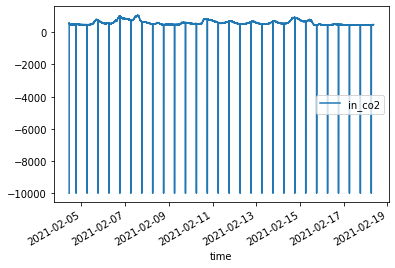

In [3]:
feature_list = input_data.columns
feature = [feature_list[0]]
input_data = input_data[feature]
input_data.plot()
plt.show()

in_co2    0
dtype: int64

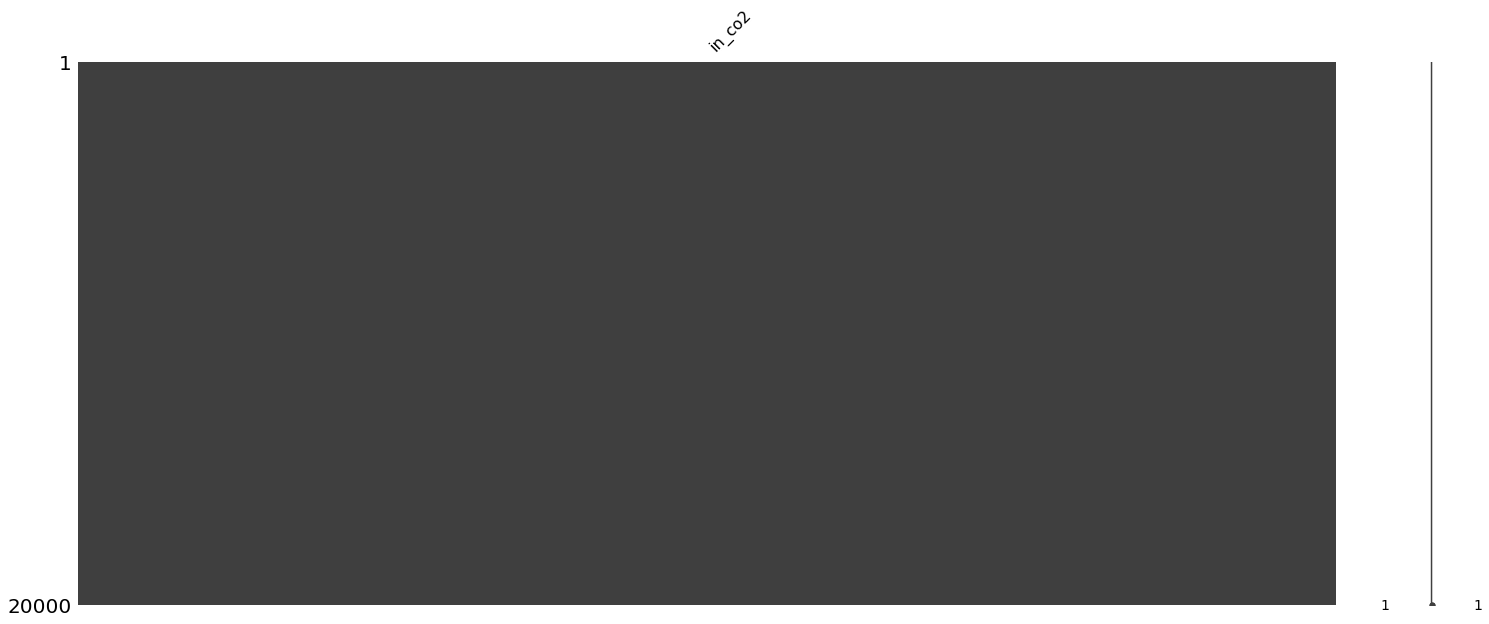

In [4]:
import missingno as msno
msno.matrix(input_data)
input_data.isna().sum()

In [5]:
### 

In [6]:
def manufacture_min_max_limit(db_client, db_name) :    
    #db에서 데이터를 가져와 민맥스 만드는 함수      
    bucket_meta = db_client.get_document_by_table('bucket', 'meta_info', db_name)        
    data_min_max_limit ={"max_num":{}, "min_num":{}}    
    
    for x in bucket_meta[0]['columnInformation'] :
        columnName  = x['columnName']
        data_min_max_limit['max_num'][columnName] = x['max']
        data_min_max_limit['min_num'][columnName] = x['min']
        
    return data_min_max_limit

def update_old_dict_to_new_dict(oldDict, newDict) :
    #db에서 가져온 데이터로 만든 민맥스를 사용자가 원하는 민맥스로 업데이트하는 함수
    oldDict['max_num'].update(newDict['max_num'])
    oldDict['min_num'].update(newDict['min_num'])
    
    #db_data는 업데이트 된 상태
    return oldDict

In [7]:
from Clust.clust.preprocessing.errorDetection import errorToNaN
from Clust.clust.ingestion.mongo import mongo_Client
db_client = mongo_Client.mongoClient(ins.CLUSTMetaInfo2)

#사용자가 원하는 민맥스
min_max_from_user ={"max_num":{"Humidity" : 700,"Temperature" : 700}, 
                    "min_num":{'RichHumidity':-70, 'comp_temp':-70}
                   }

#db에서 가져온 데이터로 만든 민맥스
min_max_from_db = manufacture_min_max_limit(db_client, db_name)

#db에서 가져온 데이터로 만든 민맥스를 사용자가 원하는 민맥스로 업데이트                                                                 
data_min_max_limit = update_old_dict_to_new_dict(min_max_from_db, min_max_from_user)

CertainParam= {'flag': True, 'data_min_max_limit':data_min_max_limit}
datawithMoreCertainNaN = errorToNaN.errorToNaN().getDataWithCertainNaN(input_data, CertainParam)

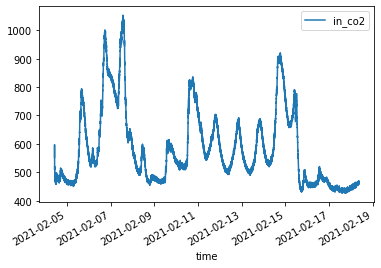

In [8]:
datawithMoreCertainNaN.plot()
plt.show()